# The Very Basics of Musical Instruments Classification using Machine Learning
## MFCC, SVM 

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/6XmEj8sqg94" 
frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture"></iframe>

## Imports

In [1]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Configurations
path='./audio/london_phill_dataset_multi/'

## Auxiliary Functions

In [2]:
# Function to Display a Website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Get filenames

In [3]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in ./audio/london_phill_dataset_multi/


## Prepare labels from filenames

In [4]:
# Get Labels
labels =[]
classes=['flute','sax','oboe', 'cello','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [5]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


## Parameters for MFCC

In [6]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Function to Calculate Audio Features: MFCC

In [7]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

## Load audio files, calculate features and create feature vectors

In [8]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_15_piano_normal.mp3
get 2 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_025_piano_normal.mp3
get 3 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_15_mezzo-forte_normal.mp3
get 4 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_05_mezzo-forte_normal.mp3
get 5 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_05_forte_normal.mp3
get 6 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_forte_minor-trill.mp3
get 7 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_As3_1_fortissimo_normal.mp3
get 8 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_025_fortissimo_normal.mp3
get 9 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_G6_025_piano_normal.mp3
get 10 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_A5_15_mezzo-forte_normal.mp3
get 11 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_A6_1_forte_minor-trill.mp3
get 12 of 600 = ./audio/london_phill_dat

get 97 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_A5_05_piano_normal.mp3
get 98 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_As3_1_piano_normal.mp3
get 99 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_05_mezzo-forte_normal.mp3
get 100 of 600 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_1_forte_major-trill.mp3
get 101 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_D6_05_forte_normal.mp3
get 102 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_C4_025_pianissimo_normal.mp3
get 103 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds4_05_forte_normal.mp3
get 104 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_15_pianissimo_normal.mp3
get 105 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_05_pianissimo_normal.mp3
get 106 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_05_mezzo-forte_normal.mp3
get 107 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_15_pianis

get 185 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_G3_15_pianissimo_normal.mp3
get 186 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_A5_025_mezzo-forte_normal.mp3
get 187 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_B4_025_forte_normal.mp3
get 188 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_A5_05_mezzo-forte_normal.mp3
get 189 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_025_forte_normal.mp3
get 190 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_G5_025_mezzo-forte_normal.mp3
get 191 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_05_forte_normal.mp3
get 192 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_05_pianissimo_normal.mp3
get 193 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_025_mezzo-forte_normal.mp3
get 194 of 600 = ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_1_pianissimo_normal.mp3
get 195 of 600 = ./audio/london_phill_datase

get 271 of 600 = ./audio/london_phill_dataset_multi/cello/cello_Gs5_1_fortissimo_arco-normal.mp3
get 272 of 600 = ./audio/london_phill_dataset_multi/cello/cello_A3_05_mezzo-piano_arco-normal.mp3
get 273 of 600 = ./audio/london_phill_dataset_multi/cello/cello_A2_1_pianissimo_arco-normal.mp3
get 274 of 600 = ./audio/london_phill_dataset_multi/cello/cello_A2_05_forte_arco-normal.mp3
get 275 of 600 = ./audio/london_phill_dataset_multi/cello/cello_Gs4_1_forte_arco-normal.mp3
get 276 of 600 = ./audio/london_phill_dataset_multi/cello/cello_Gs3_05_fortissimo_arco-normal.mp3
get 277 of 600 = ./audio/london_phill_dataset_multi/cello/cello_Gs5_15_mezzo-piano_arco-normal.mp3
get 278 of 600 = ./audio/london_phill_dataset_multi/cello/cello_A2_05_pianissimo_arco-normal.mp3
get 279 of 600 = ./audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-forte_arco-harmonic.mp3
get 280 of 600 = ./audio/london_phill_dataset_multi/cello/cello_Gs4_05_forte_arco-normal.mp3
get 281 of 600 = ./audio/london_phill_d

get 356 of 600 = ./audio/london_phill_dataset_multi/viola/viola_A3_1_piano_pizz-normal.mp3
get 357 of 600 = ./audio/london_phill_dataset_multi/viola/viola_Gs3_15_piano_arco-normal.mp3
get 358 of 600 = ./audio/london_phill_dataset_multi/viola/viola_Gs4_025_mezzo-piano_arco-normal.mp3
get 359 of 600 = ./audio/london_phill_dataset_multi/viola/viola_A3_05_mezzo-piano_arco-normal.mp3
get 360 of 600 = ./audio/london_phill_dataset_multi/viola/viola_A4_025_pianissimo_arco-normal.mp3
get 361 of 600 = ./audio/london_phill_dataset_multi/viola/viola_Gs6_15_fortissimo_arco-normal.mp3
get 362 of 600 = ./audio/london_phill_dataset_multi/viola/viola_A4_1_mezzo-forte_molto-vibrato.mp3
get 363 of 600 = ./audio/london_phill_dataset_multi/viola/viola_Gs5_025_pianissimo_arco-normal.mp3
get 364 of 600 = ./audio/london_phill_dataset_multi/viola/viola_A5_1_pianissimo_arco-normal.mp3
get 365 of 600 = ./audio/london_phill_dataset_multi/viola/viola_Gs5_025_forte_arco-normal.mp3
get 366 of 600 = ./audio/london_ph

get 444 of 600 = ./audio/london_phill_dataset_multi/flute/flute_Gs4_15_piano_normal.mp3
get 445 of 600 = ./audio/london_phill_dataset_multi/flute/flute_Gs4_15_mezzo-piano_normal.mp3
get 446 of 600 = ./audio/london_phill_dataset_multi/flute/flute_A5_15_mezzo-piano_normal.mp3
get 447 of 600 = ./audio/london_phill_dataset_multi/flute/flute_A5_15_forte_normal.mp3
get 448 of 600 = ./audio/london_phill_dataset_multi/flute/flute_Gs5_025_pianissimo_normal.mp3
get 449 of 600 = ./audio/london_phill_dataset_multi/flute/flute_A6_05_forte_normal.mp3
get 450 of 600 = ./audio/london_phill_dataset_multi/flute/flute_Gs5_15_mezzo-piano_normal.mp3
get 451 of 600 = ./audio/london_phill_dataset_multi/flute/flute_Gs4_025_mezzo-forte_normal.mp3
get 452 of 600 = ./audio/london_phill_dataset_multi/flute/flute_A6_05_mezzo-forte_normal.mp3
get 453 of 600 = ./audio/london_phill_dataset_multi/flute/flute_A5_025_mezzo-forte_normal.mp3
get 454 of 600 = ./audio/london_phill_dataset_multi/flute/flute_Gs5_15_forte_norm

get 534 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_A5_15_forte_normal.mp3
get 535 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_A4_15_piano_normal.mp3
get 536 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_forte_normal.mp3
get 537 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_A4_1_piano_normal.mp3
get 538 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_025_forte_normal.mp3
get 539 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_Ds5_1_forte_minor-trill.mp3
get 540 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_15_piano_normal.mp3
get 541 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_025_pianissimo_normal.mp3
get 542 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_1_forte_normal.mp3
get 543 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_A3_025_pianissimo_normal.mp3
get 544 of 600 = ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_025_forte_normal.mp

## Standardization: Zero-Mean and Unit-Variance

In [9]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (600, 13)


## Save / Load Feature Vector

In [10]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
#with open(filename, "rb") as f:
#    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

# Save feature_vectors for future use
with open(filename, "wb") as f:
    pickle.dump( scaled_feature_vectors, f)

## Train and Test Sets

In [11]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [12]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


## SVM Classification

In [13]:
show_web("https://en.wikipedia.org/wiki/Support_vector_machine")

In [14]:
show_web("https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html")

In [15]:
# SVM
#model_svm = LinearSVC(random_state=0, tol=1e-5, max_iter=5000)
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1) 

In [16]:
# SVM
#model_svm.fit(train_set, train_classes);
svclassifier.fit(train_set, train_classes);

### Save / Load Trained Model

In [17]:
# Save
joblib.dump(svclassifier, 'trainedSVM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

['trainedSVM.joblib']

In [18]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = svclassifier.predict(test_set)

## Evaluation

In [19]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [1.   1.   0.96 1.   1.   1.  ]
Precision:  [1.         1.         1.         1.         0.96153846 1.        ]
F1-Score:  [1.         1.         0.97959184 1.         0.98039216 1.        ]
Accuracy: 0.99  , 149
Number of samples: 150


In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [21]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

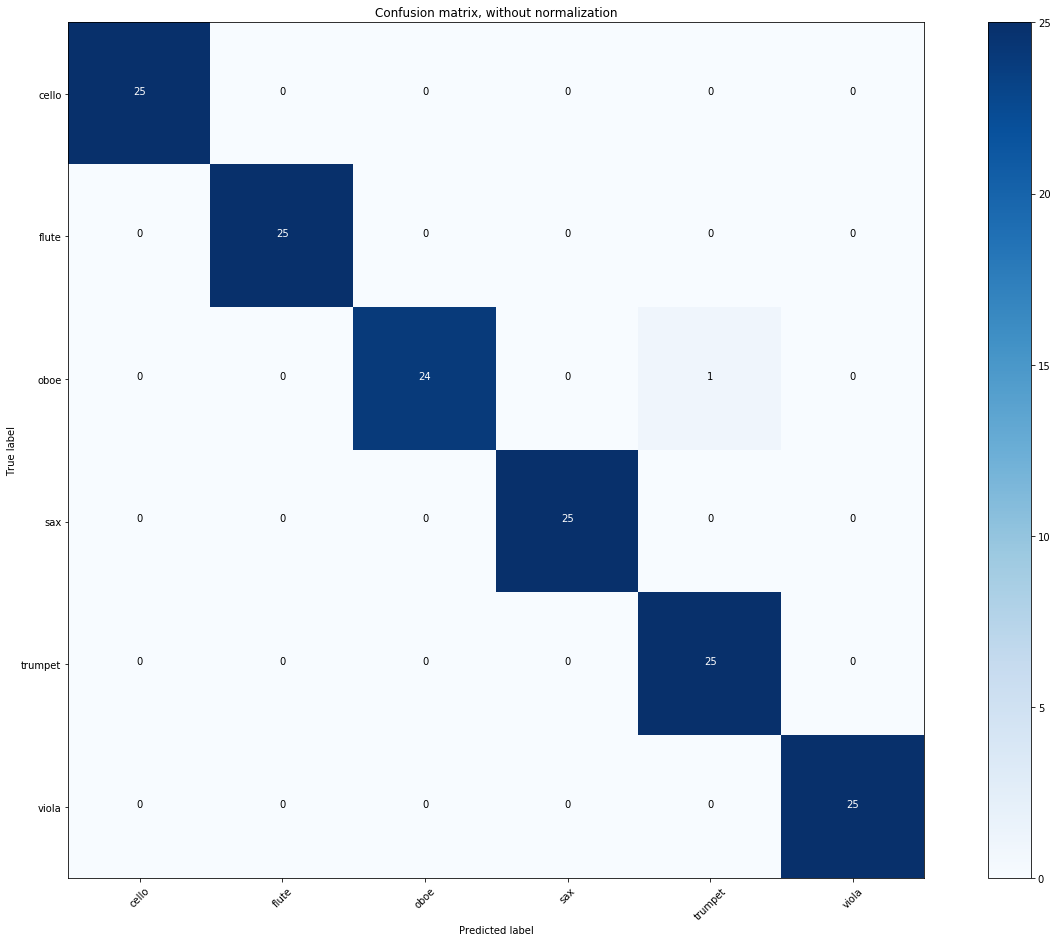

In [22]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [23]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [24]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

['oboe']
[4]
['trumpet']
['./audio/london_phill_dataset_multi/oboe/oboe_As3_05_mezzo-forte_normal.mp3']
